# NLP Toxcicty Machine Learning Model

## Imports

In [33]:
import pandas as pd
import string
import numpy as np

from nltk.corpus import stopwords, wordnet
from nltk.tokenize import RegexpTokenizer
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from matplotlib.pyplot import bar
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.multioutput import MultiOutputClassifier

import re

## Data

In [12]:
df_train= pd.read_csv('data/train.csv', index_col = 'id')

In [13]:
df_train.head(10)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0


In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159571 entries, 0000997932d777bf to fff46fc426af1f9a
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   comment_text   159571 non-null  object
 1   toxic          159571 non-null  int64 
 2   severe_toxic   159571 non-null  int64 
 3   obscene        159571 non-null  int64 
 4   threat         159571 non-null  int64 
 5   insult         159571 non-null  int64 
 6   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 9.7+ MB


In [15]:
# Function for improving parts of speech information

### get_wordnet_pos was taken from Lecture 51-nlp_modeling.ipynb 
### link to the lecture: https://github.com/dvdhartsman/NTL-DS-080723/blob/main/4phase/51-nlp_modeling.ipynb


def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [16]:
# Function for handling the transformation of data

### preprocess taken from nlp-sentiment-analysis
### link to the project: https://github.com/dvdhartsman/NLP-Sentiment-Analysis/blob/main/Text_Classification_Final_Notebook.ipynb

def preprocess(comment):
    """
    This is a function that is intended to handle all of the tokenization, lemmatization, and other
    preprocessing for our tweet data. It will make use of objects from other libraries, and will return
    a complete list of tokens that are ready to be vectorized into numerical data.
    """
    
    # Create a list of stopwords to be removed from our tokenized word list
    stops = stopwords.words("english")
    # Add punctuation to the list of stopwords
    stops += string.punctuation
    # Providing a regex pattern for the tokenizer to handle
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    # Instantiating a tokenizer
    tokenizer = RegexpTokenizer(pattern)
    # Creating a list of raw tokens
    raw_tokens = tokenizer.tokenize(comment)
    # Using a comprehension to lower case every token
    lower_tokens = [i.lower() for i in raw_tokens]
    # Remove the stopwords from the list of tokens
    stopped_words = [i for i in lower_tokens if i not in stops]
    
    # Adding parts of speech to prepare for Lemmatization
    
    # This is the initial method to get parts of speech
    stopped_words = pos_tag(stopped_words)
    
    # Get_wordnet_pos() is the function to modify the pos definitions/assignments, creates tuples of (<word>, <pos>)
    stopped_words = [(word[0], get_wordnet_pos(word[1])) for word in stopped_words]
    
    lemmatizer = WordNetLemmatizer() 
    
    # This corrects the parts of speech and maximizes the usefulness of the lemmatization!!!!!
    document = [lemmatizer.lemmatize(word[0], word[1]) for word in stopped_words]
    
    # Re-join the list of cleaned tokens
    cleaned_doc = " ".join(document)
    return cleaned_doc

In [17]:
X = df_train.comment_text
y = df_train[['toxic', 'severe_toxic', 'obscene', 'threat','insult','identity_hate']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify=['toxic', 'severe_toxic','identity_hate'])
y_toxic_train = df_train.toxic
y_severe_toxic_train = df_train.severe_toxic
y_obscene_train = df_train.obscene
y_threat_train = df_train.threat
y_insult_train = df_train['identity_hate']

In [48]:
y.sum()

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

In [22]:
y.sum().index

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

C:\Users\rchag\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


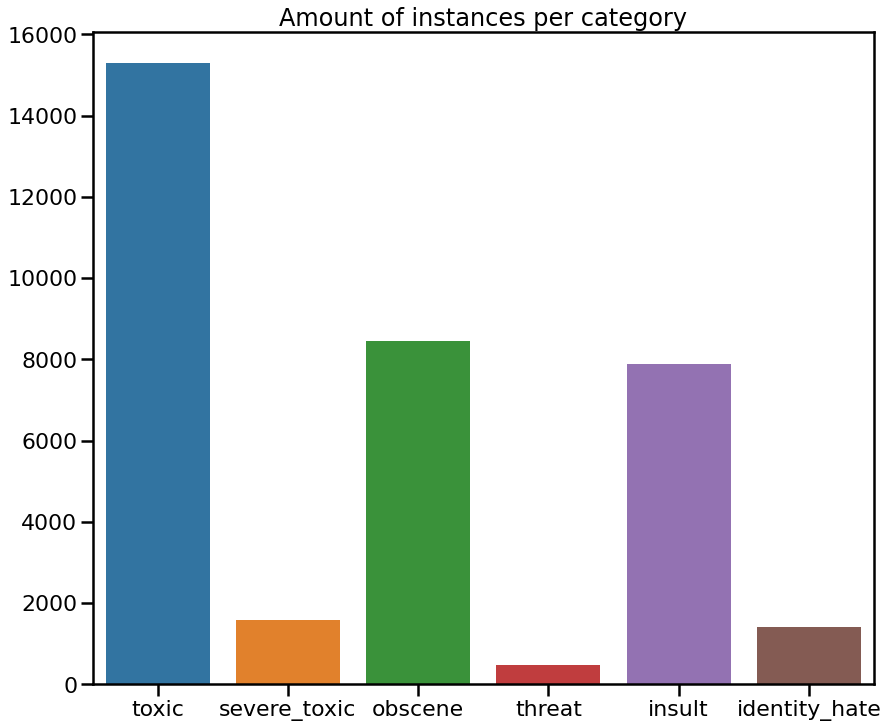

In [46]:
fig, ax = plt.subplots(figsize = (14, 12))
sns.set_context("poster")
sns.barplot(y.sum().index, y.sum().values)
ax.set_title('Amount of instances per category');

In [8]:
preprocess(X.iloc[1])

"d'aww match background colour i'm seemingly stuck thanks talk january utc"

In [9]:
X_clean = X.apply(preprocess)

In [10]:
count_vec = CountVectorizer(ngram_range=(1, 2), max_features=10000)
tf_vec = TfidfVectorizer(ngram_range=(1, 2), max_features=10000)

In [11]:
count_vec.fit(X_clean)
tf_vec.fit(X_clean)

TfidfVectorizer(max_features=10000, ngram_range=(1, 2))

In [12]:
X_count = count_vec.transform(X_clean)
X_tfidf = tf_vec.transform(X_clean)

In [13]:
X_count

<159571x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 4444977 stored elements in Compressed Sparse Row format>

In [14]:
X_tfidf

<159571x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 4444977 stored elements in Compressed Sparse Row format>

In [15]:
X_train_cv, X_test_cv, y_train, y_test = train_test_split(X_count,y, random_state = 42)

In [16]:
X_train_tf, X_test_tf, y_train, y_test = train_test_split(X_tfidf,y, random_state = 42)

In [17]:
#X_train.apply(preprocess)

"""id
0000997932d777bf    explanation edits make username hardcore metal...
000103f0d9cfb60f    d'aww match background colour i'm seemingly st...
000113f07ec002fd    hey man i'm really try edit war guy constantly...
0001b41b1c6bb37e    can't make real suggestion improvement wonder ...
0001d958c54c6e35                 sir hero chance remember page that's
                                          ...                        
ffe987279560d7ff    second time ask view completely contradict cov...
ffea4adeee384e90                 ashamed horrible thing put talk page
ffee36eab5c267c9    spitzer umm there actual article prostitution ...
fff125370e4aaaf3    look like actually put speedy first version de...
fff46fc426af1f9a    really think understand come idea bad right aw...
Name: comment_text, Length: 159571, dtype: object"""

"id\n0000997932d777bf    explanation edits make username hardcore metal...\n000103f0d9cfb60f    d'aww match background colour i'm seemingly st...\n000113f07ec002fd    hey man i'm really try edit war guy constantly...\n0001b41b1c6bb37e    can't make real suggestion improvement wonder ...\n0001d958c54c6e35                 sir hero chance remember page that's\n                                          ...                        \nffe987279560d7ff    second time ask view completely contradict cov...\nffea4adeee384e90                 ashamed horrible thing put talk page\nffee36eab5c267c9    spitzer umm there actual article prostitution ...\nfff125370e4aaaf3    look like actually put speedy first version de...\nfff46fc426af1f9a    really think understand come idea bad right aw...\nName: comment_text, Length: 159571, dtype: object"

# Modeling

In [18]:
class MultiOutput():
    # a class to more easily test, interpret and store different classifiers for a multioutput dataset
    model_list = []
    model_df = pd.DataFrame(columns = ['Classifier', 'train_accuracy','train_prec','train_recall','train_f1',
                                      'test_accuracy','test_prec','test_recall','test_f1'])
    
    def __init__(self, name, clf, X_train, X_test, y_train, y_test):
        self.name = name
        self.clf = classifier
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        
        # Measuring model
        self.train_results = cross_validate(self.model, self.X_train, self.y_train, scoring=[
            'precision', 'accuracy', 'recall', 'f1', 'neg_log_loss'], n_jobs=4, verbose=1)
        

## Baseline Dummy 

In [19]:
dummy = DummyClassifier(strategy='most_frequent')

In [20]:
dummy_clf = MultiOutputClassifier(dummy).fit(X_train_cv,y_train)

In [21]:
accuracy_score(y_train, dummy_clf.predict(X_train_cv))

0.898343889436655

In [22]:
accuracy_score(y_test, dummy_clf.predict(X_test_cv))

0.8982528263103803

In [23]:
y_train

,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,
c912439967ba8a35,0,0,0,0,0,0
b312f612d3394d5b,0,0,0,0,0,0
813c210bf7f27377,0,0,0,0,0,0
c231999bc75dcd9e,0,0,0,0,0,0
d60a1de68cf593c1,0,0,0,0,0,0
...,...,...,...,...,...,...
811ed72c51830f42,0,0,0,0,0,0
2acc7c7d0386401f,0,0,0,0,0,0
c1f95b89050a9ee4,1,0,0,0,0,0


## Logistic Regression

In [24]:
logreg_clf = MultiOutputClassifier(LogisticRegression()).fit(X_train_cv, y_train)

c:\Users\rchag\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\rchag\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

In [25]:
accuracy_score(y_train, logreg_clf.predict(X_train_cv))

0.9319590902254382

In [26]:
accuracy_score(y_test, logreg_clf.predict(X_test_cv))

0.9147970821948713

In [27]:
logreg_clf.predict(X_test_cv)

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]], dtype=int64)

In [28]:
logreg_clf_tf = MultiOutputClassifier(LogisticRegression()).fit(X_train_tf, y_train)

In [29]:
accuracy_score(y_train, logreg_clf_tf.predict(X_train_tf))

0.9246227376794398

In [30]:
accuracy_score(y_test, logreg_clf_tf.predict(X_test_tf))

0.9191336826009575

## Random Forest

In [31]:
from sklearn.ensemble import RandomForestClassifier

rfclf = MultiOutputClassifier(RandomForestClassifier(n_jobs = -1, random_state=42, max_depth=50, verbose = 1)).fit(X_train_cv, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1

In [32]:
accuracy_score(y_test, rfclf.predict(X_test_cv))

[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0

0.9049958639360289

In [33]:
rfclf_tf = MultiOutputClassifier(RandomForestClassifier(n_jobs = -1, random_state=42, max_depth=50, verbose = 1)).fit(X_train_tf, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1

In [34]:
accuracy_score(y_test, rfclf_tf.predict(X_test_tf))

[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0

0.9052716015341037

## Multinomial Naive Bayes

In [35]:
from sklearn.naive_bayes import MultinomialNB

mnb_cv = MultiOutputClassifier(MultinomialNB()).fit(X_train_cv, y_train)

In [36]:
accuracy_score(y_test, mnb_cv.predict(X_test_cv))

0.9033915724563206

In [37]:
mnb_tf = MultiOutputClassifier(MultinomialNB()).fit(X_train_tf, y_train)

In [38]:
accuracy_score(y_test, mnb_tf.predict(X_test_cv))

0.8979018875491941

In [39]:
mnb_tf.predict(X_test_cv)

array([[1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]], dtype=int64)

## Sequential

In [102]:
from keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, TextVectorization
from keras.layers import Dropout

from sklearn.metrics import hamming_loss

In [41]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [67]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [107]:
def get_model(n_inputs, n_outputs, dropout = None, layer_amnt = 1):    
    model = Sequential()
    if dropout != None:
        model.add(Dropout(0.2, input_shape = (n_inputs,)))
    else:
        model.add(Dense(128, input_dim = n_inputs, activation = 'relu'))
    for i in range(layer_amnt):
        model.add(Dense(128, activation = 'relu'))
    model.add(Dense(n_outputs, activation = 'sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

In [43]:
# Keras vectorizer inpsired by
# https://www.kaggle.com/code/mostafamohammednouh/logistic-regression-for-toxic-comments

max_features = 20000

vectorizer = TextVectorization(max_tokens = max_features,
                               ngrams = 2,
                               output_mode = 'int')


In [44]:
vectorizer.adapt(X.values)

In [45]:
X_vectorized = vectorizer(X.values)

In [46]:
dataset = tf.data.Dataset.from_tensor_slices((X_vectorized, y))

In [47]:
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [48]:
train_batch = dataset.as_numpy_iterator().next()
train_batch

(array([[   7,   84,   20, ...,    0,    0,    0],
        [ 324,  130,    4, ...,    0,    0,    0],
        [6165,   19, 4911, ...,    0,    0,    0],
        ...,
        [  42,   83,    8, ...,    0,    0,    0],
        [4822,   16,   21, ...,    0,    0,    0],
        [1306,    1,  377, ...,    0,    0,    0]], dtype=int64),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]], dtype=int64))

In [49]:
train = dataset.take(int(len(dataset)*.9))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.05))   # 5%
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.05))

In [50]:
nn_new = Sequential()

nn_new.add(Embedding(10001, 32))
nn_new.add(Bidirectional(LSTM(32, activation = 'tanh')))
nn_new.add(Dense(128, activation = 'relu'))
nn_new.add(Dense(128, activation = 'relu'))
nn_new.add(Dense(128, activation = 'relu'))
nn_new.add(Dense(6, activation = 'sigmoid'))

In [51]:
nn_new.compile(optimizer='Adam',
               loss= 'binary_crossentropy',
               metrics = ['accuracy'])

In [52]:
nn_new.fit(dataset, epochs=3, validation_data=val, verbose = 1)

Epoch 1/3
9974/9974 [==============================] - 1582s 158ms/step - loss: 0.0629 - accuracy: 0.9908 - val_loss: 0.0557 - val_accuracy: 0.9923
Epoch 2/3
9974/9974 [==============================] - 1568s 157ms/step - loss: 0.0522 - accuracy: 0.9908 - val_loss: 0.0458 - val_accuracy: 0.9923
Epoch 3/3
9974/9974 [==============================] - 1560s 156ms/step - loss: 0.0478 - accuracy: 0.9926 - val_loss: 0.0442 - val_accuracy: 0.9937


In [53]:
nn_new.evaluate(test)

498/498 [==============================] - 40s 75ms/step - loss: 0.0455 - accuracy: 0.9937


[0.04548230394721031, 0.9937248826026917]

In [118]:
nn_new.save(filepath='../Toxic-Comment-Classification-Challenge/nn_new.keras')

### Neural Network 300

In [82]:
nn2 = get_model(300, y_train.shape[1])

In [60]:
X_train_cv_df = pd.DataFrame(X_train_cv.toarray())
X_test_cv_df = pd.DataFrame(X_test_cv.toarray())

In [61]:
X_train_cv_300 = X_train_cv_df.iloc[:,0:300]

In [62]:
X_train_cv_300.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
nn2.fit(X_train_cv_300, y_train, verbose = 1, epochs = 3)

Epoch 1/3
3740/3740 [==============================] - 6s 1ms/step - loss: 0.1436 - accuracy: 0.9809
Epoch 2/3
3740/3740 [==============================] - 6s 1ms/step - loss: 0.1357 - accuracy: 0.9908
Epoch 3/3
3740/3740 [==============================] - 6s 2ms/step - loss: 0.1349 - accuracy: 0.9866


In [117]:
nn2.save(filepath='../Toxic-Comment-Classification-Challenge/nn2.keras')

In [84]:
X_test_cv_300 = X_test_cv_df.iloc[:,0:300]

In [85]:
nn2.evaluate(X_test_cv_300, y_test)

1247/1247 [==============================] - 2s 1ms/step - loss: 0.1381 - accuracy: 0.9930


[0.13806480169296265, 0.9929561614990234]

### Neural Network dropout

In [93]:
X_train_cv_1000 = X_train_cv_df.iloc[:,0:1000]
X_test_cv_1000 = X_test_cv_df.iloc[:,0:1000]

In [120]:
nn_1000 = get_model(1000, 6, layer_amnt = 3)

In [122]:
nn_1000.fit(X_train_cv_1000, y_train, verbose = 1, epochs=3)

Epoch 1/3
3740/3740 [==============================] - 6s 2ms/step - loss: 0.1305 - accuracy: 0.9864
Epoch 2/3
3740/3740 [==============================] - 6s 2ms/step - loss: 0.1173 - accuracy: 0.9915
Epoch 3/3
3740/3740 [==============================] - 6s 2ms/step - loss: 0.1147 - accuracy: 0.9923


In [127]:
nn_1000.evaluate(X_test_cv_1000,y_test)

1247/1247 [==============================] - 1s 977us/step - loss: 0.1210 - accuracy: 0.9827


[0.12098955363035202, 0.9826786518096924]

In [131]:
nn_1000_test = nn_1000.predict(X_test_cv_1000)

In [132]:
nn_1000_test = nn_1000_test.round()

In [133]:
accuracy_score(y_test, nn_1000_test)

0.901536610432908

In [135]:
hamming_loss(y_test, nn_1000_test)

0.03322220272562438

In [136]:
nn_1000.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 128)               128128    
_________________________________________________________________
dense_38 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_39 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_40 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_41 (Dense)             (None, 6)                 774       
Total params: 178,438
Trainable params: 178,438
Non-trainable params: 0
_________________________________________________________________


In [ ]:
nn1000.save(filepath='../Toxic-Comment-Classification-Challenge/nn_new.keras')

In [116]:
print(tf.keras.backend.learning_phase())

0


### NND 2

In [137]:
nndrop2 = get_model(1000, 6, dropout = True, layer_amnt = 2)

In [138]:
nndrop2.fit(X_train_cv_1000, y_train, verbose = 1, epochs=3)

Epoch 1/3
3740/3740 [==============================] - 6s 2ms/step - loss: 0.1364 - accuracy: 0.9845
Epoch 2/3
3740/3740 [==============================] - 6s 2ms/step - loss: 0.1212 - accuracy: 0.9836
Epoch 3/3
3740/3740 [==============================] - 6s 2ms/step - loss: 0.1204 - accuracy: 0.9807


In [139]:
nndrop2_test = nndrop2.predict(X_test_cv)
nndrop2_test = nndrop2_test.round()
accuracy_score(y_test, nndrop2_test)

0.9013611410523149

In [140]:
nndrop2.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_6 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_42 (Dense)             (None, 128)               128128    
_________________________________________________________________
dense_43 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_44 (Dense)             (None, 6)                 774       
Total params: 145,414
Trainable params: 145,414
Non-trainable params: 0
_________________________________________________________________


### NN TF-IDF

In [149]:
X_train_tf_df = pd.DataFrame(X_train_tf.toarray())
X_test_tf_df = pd.DataFrame(X_test_tf.toarray())

MemoryError: Unable to allocate 8.92 GiB for an array with shape (119678, 10000) and data type float64

In [142]:
nntf = get_model(X_train_tf_df.shape[1], y_train.shape[1], layer_amnt=3)

NameError: name 'X_train_tf_df' is not defined

In [ ]:
tf.sparse.reorder
nntf.fit(X_train_tf_df, y_train, epochs = 10, verbose=1, shuffle = True)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
nntf_test = nntf.predict(X_test_tf_df)
nntf_test = nntf_test.round()
accuracy_score(y_test, nntf_test)

0.9037425112175068

### NNTF Dropout

In [ ]:
nntf_drop = get_model(X_train_tf_df.shape[1], y_train.shape[1],dropout = True, layer_amnt=3)

In [ ]:
tf.sparse.reorder
nntf_drop.fit(X_train_tf_df, y_train, epochs = 10, verbose = True)

Epoch 1/10
3740/3740 [==============================] - 17s 5ms/step - loss: 0.0252
Epoch 2/10
3740/3740 [==============================] - 17s 5ms/step - loss: 0.0244
Epoch 3/10
3740/3740 [==============================] - 17s 4ms/step - loss: 0.0241
Epoch 4/10
3740/3740 [==============================] - 18s 5ms/step - loss: 0.0220
Epoch 5/10
3740/3740 [==============================] - 18s 5ms/step - loss: 0.0219
Epoch 6/10
3740/3740 [==============================] - 18s 5ms/step - loss: 0.0209
Epoch 7/10
3740/3740 [==============================] - 18s 5ms/step - loss: 0.0203
Epoch 8/10
3740/3740 [==============================] - 18s 5ms/step - loss: 0.0199
Epoch 9/10
3740/3740 [==============================] - 18s 5ms/step - loss: 0.0194
Epoch 10/10
3740/3740 [==============================] - 18s 5ms/step - loss: 0.0191


In [ ]:
nntf_drop_test = nntf_drop.predict(X_test_tf_df)
nntf_drop_test = nntf_drop_test.round()
accuracy_score(y_test, nntf_drop_test)

0.9100343418644875

In [99]:
hamming_loss(y_test, nntf_drop_test)

NameError: name 'hamming_loss' is not defined

### Embedded NN

In [ ]:
nntf_drop_em7 = Sequential()

In [ ]:
nntf_drop_em7.add(layers.Embedding(10001, 32))
nntf_drop_em7.add(layers.Bidirectional(layers.LSTM(32, activation = 'tanh')))
nntf_drop_em7.add(layers.Dense(128, activation='relu'))
nntf_drop_em7.add(layers.Dense(128, activation='relu'))
nntf_drop_em7.add(layers.Dense(128, activation='relu'))
nntf_drop_em7.add(layers.Dense(6, activation='sigmoid'))
nntf_drop_em7.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
# Our vectorized labels
#https://stackoverflow.com/questions/48851558/tensorflow-estimator-valueerror-logits-and-labels-must-have-the-same-shape
y_train_rs = np.asarray(y_train).astype('float32').reshape((-1,6))
y_test_rs = np.asarray(y_test).astype('float32').reshape((-1,6))

In [ ]:
tf_df = tf_gpu.convert_to_tensor(X_train_tf_df)

NameError: name 'tf_gpu' is not defined

In [ ]:
y_train_rs

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
nntf_drop_em7.fit(tf_df, y_train, epochs = 10, verbose = True)

NameError: name 'nntf_drop_em7' is not defined

In [ ]:
nntf_drop_em4.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320032    
_________________________________________________________________
dense_4 (Dense)              (None, None, 128)         4224      
_________________________________________________________________
dense_5 (Dense)              (None, None, 128)         16512     
_________________________________________________________________
dense_6 (Dense)              (None, None, 128)         16512     
_________________________________________________________________
dense_7 (Dense)              (None, None, 6)           774       
Total params: 358,054
Trainable params: 358,054
Non-trainable params: 0
_________________________________________________________________
